### Classification and regression trees

#### CART is represented by binary tree.
#### A node represents a single input variable (X) and a split point on that variable, assuming the variable is numeric. 
#### The leaf nodes (also called terminal nodes) of the tree contain an output variable (y) which is used to make a prediction.
#### Creating a binary decision tree is actually a process of dividing up the input space. A greedy approach is used to divide the space called recursive binary splitting. 
####  Different split points are tried and tested using a cost function. The split with the best cost (lowest cost because we minimize cost) is selected.
#### Regression: cost function is sum of squared errors.
#### Classification: Gini cost function is used. It provides an indication of how pure the nodes are. Node purity mean how mixed the training data assigned to each node is.
#### Splitting continues until nodes contain a minimum number of training examples or a maximum tree depth is reached.


### 1 - Gini Index
#### A Gini score gives an idea of how good a split is by how mixed the classes are in the two groups created by the split. A perfect separation results in a Gini score of 0, whereas the worst case split that results in 50/50 classes in each group result in a Gini score of 0.5 (for a 2 class problem).


#### proportion = count(class_value) / count(rows)
#### Gini is calculated for each child node as follows:

#### gini_index = 1.0 - sum(proportion * proportion)

#### The Gini index for each group must then be weighted by the size of the group, relative to all of the samples in the parent.
#### gini_index = (1.0 - sum(proportion * proportion)) * (group_size/total_samples)

#### The scores are then added across each child node at the split point to give a final Gini score for the split point that can be compared to other candidate split points.

In [1]:
def gini_index(groups, classes):
    
    # All samples at split point
    n_instances = sum([len(group) for group in groups])
    
    gini = 0
    for group in groups:
        group_size = len(group)
        
        score = 0
        for class_val in classes:
            
            
            p = [row[-1] for row in group].count(class_val)/group_size
            
            score += p*p
        gini+= (1 - score)*group_size/n_instances
    
    return gini

### 2- Create Split
#### 2.1 Split the dataset


#### Splitting a dataset means separating a dataset into two lists of rows given the index of an attribute and a split value for that attribute. Once we have the two groups, we can then use our Gini score above to evaluate the cost of the split.
#### Splitting a dataset involves iterating over each row, checking if the attribute value is below or above the split value and assigning it to the left or right group respectively.

In [2]:
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

#### 2.2 Evaluate all splits

#### Given a dataset, we must check every value on each attribute as a candidate split, evaluate the cost of the split and find the best possible split we could make. Once the best split is found, we can use it as a node in our decision tree. This is an exhaustive and greedy algorithm.
#### When selecting the best split and using it as a new node for the tree we will store the index of the chosen attribute, the value of that attribute by which to split and the two groups of data split by the chosen split point.
#### Below is a function named get_split() that implements this procedure. You can see that it iterates over each attribute (except the class value) and then each value for that attribute, splitting and evaluating splits as it goes.


In [6]:
# Select the best split point for a dataset
def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

#### Example

In [ ]:
X1                    X2        Y
2.771244718		1.784783929		0
1.728571309		1.169761413		0
3.678319846		2.81281357		0
3.961043357		2.61995032		0
2.999208922		2.209014212		0
7.497545867		3.162953546		1
9.00220326		3.339047188		1
7.444542326		0.476683375		1
10.12493903		3.234550982		1
6.642287351		3.319983761		1



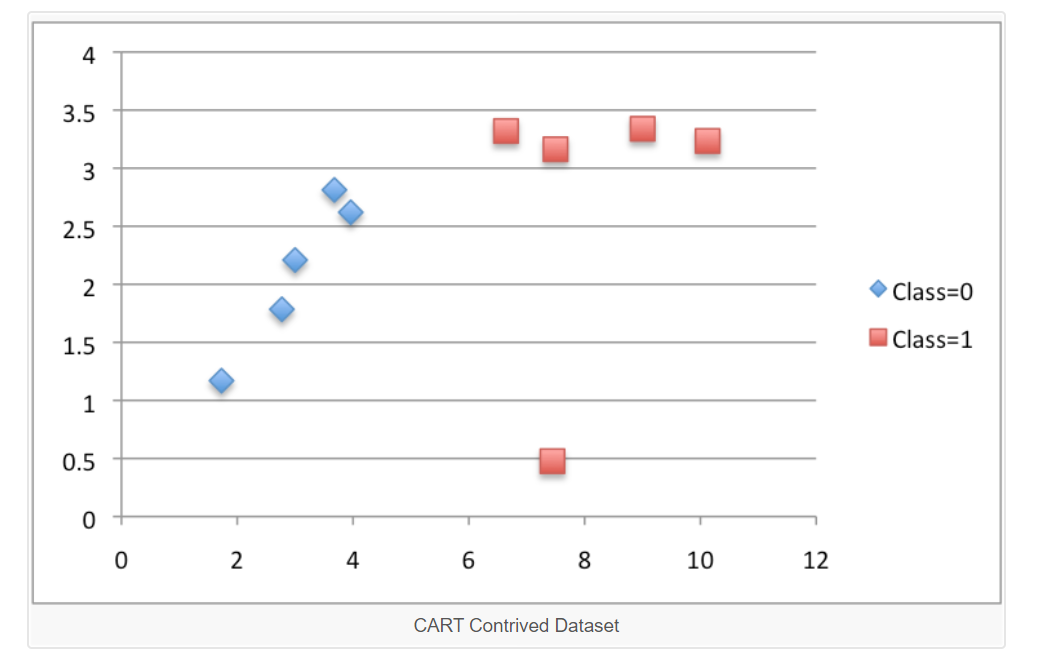

#### Putting it together

In [9]:
dataset = [[2.771244718,1.784783929,0],
	[1.728571309,1.169761413,0],
	[3.678319846,2.81281357,0],
	[3.961043357,2.61995032,0],
	[2.999208922,2.209014212,0],
	[7.497545867,3.162953546,1],
	[9.00220326,3.339047188,1],
	[7.444542326,0.476683375,1],
	[10.12493903,3.234550982,1],
	[6.642287351,3.319983761,1]]

split = get_split(dataset)
print('Split: [X%d < %.3f]' % ((split['index']+1), split['value']))

In [ ]:

X1 < 2.771 Gini=0.444
X1 < 1.729 Gini=0.500
X1 < 3.678 Gini=0.286
X1 < 3.961 Gini=0.167
X1 < 2.999 Gini=0.375
X1 < 7.498 Gini=0.286
X1 < 9.002 Gini=0.375
X1 < 7.445 Gini=0.167
X1 < 10.125 Gini=0.444
X1 < 6.642 Gini=0.000
X2 < 1.785 Gini=0.500
X2 < 1.170 Gini=0.444
X2 < 2.813 Gini=0.320
X2 < 2.620 Gini=0.417
X2 < 2.209 Gini=0.476
X2 < 3.163 Gini=0.167
X2 < 3.339 Gini=0.444
X2 < 0.477 Gini=0.500
X2 < 3.235 Gini=0.286
X2 < 3.320 Gini=0.375
Split: [X1 < 6.642]


### 3 - Built a tree
#### Terminal Nodes
#### Recursive Splitting
#### Building a Tree

#### 3.1 Terminal nodes: we need to decide when to stop growing the tree.
     Max tree depth
     Min node record
     
#### Now we have some ideas of when to stop growing the tree. When we do stop growing at a given point, that node is called a terminal node and is used to make a final prediction. This is done by taking the group of rows assigned to that node and selecting the most common class value in the group. This will be used to make predictions.

In [ ]:
# Create a terminal node value
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)


#### 3.2 Recursive splitting
#### We know how and when to create terminal nodes, now we can build our tree.
#### New nodes added to an existing node are called child nodes. A node may have zero children (a terminal node), one child (one side makes a prediction directly) or two child nodes. 
#### Once a node is created, we can create child nodes recursively on each group of data from the split by calling the same function again.

##### 1 - Firstly, the two groups of data split by the node are extracted for use and deleted from the node. As we work on these groups the node no longer requires access to these data.
##### 2 - Next, we check if either left or right group of rows is empty and if so we create a terminal node using what records we do have.
##### 3 -We then check if we have reached our maximum depth and if so we create a terminal node.
##### 4 -We then process the left child, creating a terminal node if the group of rows is too small, otherwise creating and adding the left node in a depth first fashion until the bottom of the tree is reached on this branch.
##### 5 - The right side is then processed in the same manner, as we rise back up the constructed tree to the root.

In [ ]:
# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

#### 3.3 Building a tree
#### Building the tree involves creating the root node and calling the split() function that then calls itself recursively to build out the whole tree.

In [10]:

# Build a decision tree
def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root


### 4-Make a Prediction



In [ ]:
# Make a prediction with a decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

In [ ]:
# Classification and Regression Tree Algorithm
def decision_tree(train, test, max_depth, min_size):
    tree = build_tree(train, max_depth, min_size)
    predictions = list()
    for row in test:
        prediction = predict(tree, row)
        predictions.append(prediction)
    return(predictions)

### References

#### https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/
#### https://towardsdatascience.com/decision-tree-from-scratch-in-python-46e99dfea775
#### https://towardsdatascience.com/random-forests-and-decision-trees-from-scratch-in-python-3e4fa5ae4249
#### Data Science from Scratch